# **Importing Packages**

In [ ]:
%matplotlib inline

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures

import numpy as np
import pandas as pd
import math
import seaborn
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from numpy import mean
from numpy import std
from tqdm import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("500")')

# **Loading the dataset**

In [ ]:
def data_loader():
    ''' Function to load the data directly from Github repository where the data file has been stored.
        Data file contained headers in German which were translated to English.
    ''' 
    data = pd.read_excel("https://github.com/AmeyGohil/ME781_Project/blob/master/CoDiP_couples_Big%20Five_RASII.xlsx?raw=truea", header = 1)
    data = data.rename(columns={"relationship duration in months": "relationship duration in months.1", "relationship duration in months.1": "relationship duration in months.2"})
    # 
    data = data.rename(columns={"relationship duration in months": "relationship duration in months.1", "relationship duration in months.1": "relationship duration in months.2"})
    return data
data = data_loader()
data

,Label,Pair code,Gender.1,Gender.2,sd02T1.1: Age (years),sd02T1.2: Age (years),sd04T1.1: Civil Status,sd04T1.2: Civil Status,sd05aT1.1: If relationship (duration in months),sd05aT1.2: If relationship (duration in months),relationship duration in months.2,relationship duration in months.2,mean neuroticism female,mean neuroticism male,mean extraversion female,mean extraversion male,mean openness female,mean openness male,mean agreeableness female,mean agreeableness male,mean conscientiousness female,mean conscientiousness male,mean relationship satisfaction female,mean relationship satisfaction male,mean relationship satisfaction T2 female,mean relationship satisfaction T2 male,pooled standardized neuroticism female,pooled standardized neuroticism male,pooled standardized extraversion female,pooled standardized extraversion male,pooled standardized openness female,pooled standardized openness male,pooled standardized agreeableness female,pooled standardized agreeableness male,pooled standardized conscientiousness female,pooled standardized conscientiousness male,pooled standardized relationship satisfaction female,pooled standardized relationship satisfaction male,pooled standardized relationship satisfaction T2 female,pooled standardized relationship satisfaction T2 male
0,NaN,1,1,2,20,26,1,1,15.0,16.0,15.0,16.0,2.750,3.250000,3.625,2.500,3.2,4.3,3.600000,3.9,3.777778,3.555556,4.285714,4.714286,NaN,NaN,-0.227657,1.138554,-0.149842,-1.497379,-0.817428,1.118620,-0.633697,0.252855,-0.456858,-0.684944,0.117514,0.666079,NaN,NaN
1,NaN,2,1,2,77,77,2,2,888.0,888.0,586.0,586.0,2.625,2.375000,4.375,3.500,3.5,3.4,4.300000,3.9,4.666667,4.222222,4.857143,4.714286,4.857143,5.000000,-0.405093,-0.103495,0.944321,-0.038495,-0.280348,-0.492620,0.827201,0.252855,1.074896,0.463872,1.022010,0.666079,0.995357,1.131113
2,NaN,3,1,2,53,55,2,2,888.0,888.0,258.0,248.0,1.625,1.875000,4.250,3.875,4.0,4.3,4.666667,4.2,4.222222,4.111111,4.285714,4.571429,NaN,NaN,-1.824577,-0.813238,0.761961,0.508587,0.614785,1.118620,1.592433,0.878954,0.309019,0.272402,0.117514,0.439955,NaN,NaN
3,NaN,4,1,2,20,20,1,1,36.0,35.0,36.0,35.0,2.875,1.500000,3.000,2.875,3.4,3.0,4.300000,3.7,3.000000,3.666667,4.428571,4.714286,4.571429,4.857143,-0.050221,-1.345544,-1.061645,-0.950298,-0.459375,-1.208727,0.827201,-0.164544,-1.797143,-0.493475,0.343638,0.666079,0.518802,0.892836
4,NaN,5,1,2,49,55,2,2,888.0,888.0,326.0,326.0,2.500,2.750000,4.625,3.500,4.0,3.9,3.800000,3.2,3.555556,4.222222,3.000000,3.857143,2.571429,3.857143,-0.582528,0.428812,1.309042,-0.038495,0.614785,0.402513,-0.216298,-1.208043,-0.839796,0.463872,-1.917601,-0.690665,-2.817080,-0.775105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,NaN,233,1,2,51,51,2,2,888.0,888.0,285.0,285.0,1.500,2.142857,3.375,2.375,3.6,4.3,4.000000,4.3,4.222222,3.333333,4.000000,4.285714,4.714286,4.571429,-2.002013,-0.433018,-0.514564,-1.679740,-0.101321,1.118620,0.201102,1.087654,0.309019,-1.067883,-0.334733,-0.012293,0.757080,0.416281
233,NaN,234,1,2,25,29,1,1,22.0,22.0,22.0,22.0,2.000,3.250000,4.375,3.000,4.0,3.2,3.900000,3.6,4.444444,4.111111,4.714286,4.428571,NaN,NaN,-1.292271,1.138554,0.944321,-0.767937,0.614785,-0.850673,-0.007598,-0.373244,0.691958,0.272402,0.795886,0.213831,NaN,NaN
234,NaN,235,1,2,29,29,1,1,84.5,84.5,84.5,84.5,3.375,2.750000,3.625,3.500,4.0,4.6,4.000000,3.5,4.000000,4.000000,4.428571,4.714286,3.571429,4.428571,0.659521,0.428812,-0.149842,-0.038495,0.614785,1.655700,0.201102,-0.581944,-0.073919,0.080933,0.343638,0.666079,-1.149139,0.178004
235,NaN,236,1,2,25,25,1,1,81.5,81.5,81.5,81.5,2.000,2.500000,4.375,3.125,3.9,3.4,4.100000,3.7,4.666667,3.000000,4.428571,4.428571,4.571429,4.428571,-1.292271,0.073940,0.944321,-0.585576,0.435759,-0.492620,0.409801,-0.164544,1.074896,-1.642290,0.343638,0.213831,0.518802,0.178004


# **Subsetting the dataset | Extracting only the necessary columns**


*   sd05aT1.1 and sd05aT1.2 are again reported in the very next 2 columns (reldur.1, reldur.2). Hence, sd05aT1.1 and sd05aT1.2 dropped
*   Column 1 named Label is useless



In [ ]:
def data_drop(data):
    '''
        Function to drop the unnecessary variables in the dataframe which are redundant/ repeated. 
        Note: This is not the function used to extract only relevant columns for computation. This function is used to omit redundancy.
    '''
    data = data.drop(["Label", "sd05aT1.1: If relationship (duration in months)", "sd05aT1.2: If relationship (duration in months)"], axis = 1)
    return data
data_drop(data)

,Pair code,Gender.1,Gender.2,sd02T1.1: Age (years),sd02T1.2: Age (years),sd04T1.1: Civil Status,sd04T1.2: Civil Status,relationship duration in months.2,relationship duration in months.2,mean neuroticism female,mean neuroticism male,mean extraversion female,mean extraversion male,mean openness female,mean openness male,mean agreeableness female,mean agreeableness male,mean conscientiousness female,mean conscientiousness male,mean relationship satisfaction female,mean relationship satisfaction male,mean relationship satisfaction T2 female,mean relationship satisfaction T2 male,pooled standardized neuroticism female,pooled standardized neuroticism male,pooled standardized extraversion female,pooled standardized extraversion male,pooled standardized openness female,pooled standardized openness male,pooled standardized agreeableness female,pooled standardized agreeableness male,pooled standardized conscientiousness female,pooled standardized conscientiousness male,pooled standardized relationship satisfaction female,pooled standardized relationship satisfaction male,pooled standardized relationship satisfaction T2 female,pooled standardized relationship satisfaction T2 male
0,1,1,2,20,26,1,1,15.0,16.0,2.750,3.250000,3.625,2.500,3.2,4.3,3.600000,3.9,3.777778,3.555556,4.285714,4.714286,NaN,NaN,-0.227657,1.138554,-0.149842,-1.497379,-0.817428,1.118620,-0.633697,0.252855,-0.456858,-0.684944,0.117514,0.666079,NaN,NaN
1,2,1,2,77,77,2,2,586.0,586.0,2.625,2.375000,4.375,3.500,3.5,3.4,4.300000,3.9,4.666667,4.222222,4.857143,4.714286,4.857143,5.000000,-0.405093,-0.103495,0.944321,-0.038495,-0.280348,-0.492620,0.827201,0.252855,1.074896,0.463872,1.022010,0.666079,0.995357,1.131113
2,3,1,2,53,55,2,2,258.0,248.0,1.625,1.875000,4.250,3.875,4.0,4.3,4.666667,4.2,4.222222,4.111111,4.285714,4.571429,NaN,NaN,-1.824577,-0.813238,0.761961,0.508587,0.614785,1.118620,1.592433,0.878954,0.309019,0.272402,0.117514,0.439955,NaN,NaN
3,4,1,2,20,20,1,1,36.0,35.0,2.875,1.500000,3.000,2.875,3.4,3.0,4.300000,3.7,3.000000,3.666667,4.428571,4.714286,4.571429,4.857143,-0.050221,-1.345544,-1.061645,-0.950298,-0.459375,-1.208727,0.827201,-0.164544,-1.797143,-0.493475,0.343638,0.666079,0.518802,0.892836
4,5,1,2,49,55,2,2,326.0,326.0,2.500,2.750000,4.625,3.500,4.0,3.9,3.800000,3.2,3.555556,4.222222,3.000000,3.857143,2.571429,3.857143,-0.582528,0.428812,1.309042,-0.038495,0.614785,0.402513,-0.216298,-1.208043,-0.839796,0.463872,-1.917601,-0.690665,-2.817080,-0.775105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,233,1,2,51,51,2,2,285.0,285.0,1.500,2.142857,3.375,2.375,3.6,4.3,4.000000,4.3,4.222222,3.333333,4.000000,4.285714,4.714286,4.571429,-2.002013,-0.433018,-0.514564,-1.679740,-0.101321,1.118620,0.201102,1.087654,0.309019,-1.067883,-0.334733,-0.012293,0.757080,0.416281
233,234,1,2,25,29,1,1,22.0,22.0,2.000,3.250000,4.375,3.000,4.0,3.2,3.900000,3.6,4.444444,4.111111,4.714286,4.428571,NaN,NaN,-1.292271,1.138554,0.944321,-0.767937,0.614785,-0.850673,-0.007598,-0.373244,0.691958,0.272402,0.795886,0.213831,NaN,NaN
234,235,1,2,29,29,1,1,84.5,84.5,3.375,2.750000,3.625,3.500,4.0,4.6,4.000000,3.5,4.000000,4.000000,4.428571,4.714286,3.571429,4.428571,0.659521,0.428812,-0.149842,-0.038495,0.614785,1.655700,0.201102,-0.581944,-0.073919,0.080933,0.343638,0.666079,-1.149139,0.178004
235,236,1,2,25,25,1,1,81.5,81.5,2.000,2.500000,4.375,3.125,3.9,3.4,4.100000,3.7,4.666667,3.000000,4.428571,4.428571,4.571429,4.428571,-1.292271,0.073940,0.944321,-0.585576,0.435759,-0.492620,0.409801,-0.164544,1.074896,-1.642290,0.343638,0.213831,0.518802,0.178004


# **Implementation of Neural Network**

---



---



**Idea**: Implement a MLP with:
- Input: Big 5 trait values of both male and female
- Train network with MSE loss and SGD optimizer
- Output: Relationship satisfaction scores of both male and female.

In [ ]:
####################################################################
## Subsetting the data as per requirement of our MLP
####################################################################
def data_extraction(data):
    '''
        Input: Dataframe containing all the non-redundant columns 
        Extracts the relevant columns for our analysis. Those include age, the trait scores (standardized) and the relationship satisfaction scores.
        Also drops the NaN responses in the extracted dataframe and returns the clean processed data.
        Output: Feature matrix X containing only the relevant data columns, Response variables (satisfaction scores of both male and female) 
    '''
    # reqd_data = data[["pooled standardized neuroticism female", "pooled standardized neuroticism male", "pooled standardized extraversion female", "pooled standardized extraversion male","pooled standardized openness female", "pooled standardized openness male", "pooled standardized agreeableness female", "pooled standardized agreeableness male", "pooled standardized conscientiousness female", "pooled standardized conscientiousness male", "pooled standardized relationship satisfaction female", "pooled standardized relationship satisfaction male"]]
    reqd_data = data[["mean neuroticism female","mean neuroticism male","mean extraversion female","mean extraversion male","mean openness female","mean openness male","mean agreeableness female","mean agreeableness male","mean conscientiousness female","mean conscientiousness male","mean relationship satisfaction female","mean relationship satisfaction male"]]
    reqd_data = reqd_data.dropna() 
    reqd_data['mean relationship satisfaction'] = reqd_data[reqd_data.columns[-2:]].mean(axis = 1)
    X = reqd_data[reqd_data.columns[:-3]]
    y = reqd_data['mean relationship satisfaction']
    return X,y

X,y = data_extraction(data)

In [ ]:
############################################
## Creating the Neural Network architecture
############################################
def mlp_model(n_inputs, n_outputs):
    '''
        Creating the MLP architecture. 
        Number of hidden layers in this architecture = 1
        Number of input neurons = Number of feature vectors considered
        Number of outpur neurons = 1 (corresponding to the mean relationship score)
        Loss considered: MSE
        Optimizer: SGD
    '''
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='sgd')
    return model

In [ ]:
################################################################
## Evaluating the model using repeated k-fold cross-validation
################################################################

def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], 1
	# define evaluation procedure
	cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
		y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
		# define model
		model = mlp_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose = 0, epochs = 200)
		# evaluate model on test set
		mse = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('\033[1mMSE value at current fold->\033[0m  %.3f' % mse)
		results.append(mse)
        
	return results
 
## evaluate model
results = evaluate_model(X, y)

## summarize performance
print("*****************End of Evaluation********************")
print('Summary: Mean MSE: %.3f (with SD: %.3f)' % (mean(results), std(results)))

MSE value at current fold->  0.493
MSE value at current fold->  0.230
MSE value at current fold->  0.434
MSE value at current fold->  0.217
MSE value at current fold->  0.128
MSE value at current fold->  0.322
MSE value at current fold->  0.452
MSE value at current fold->  0.452
MSE value at current fold->  0.302
MSE value at current fold->  0.568
MSE value at current fold->  0.432
MSE value at current fold->  0.364
MSE value at current fold->  0.304
MSE value at current fold->  0.336
MSE value at current fold->  0.414
MSE value at current fold->  0.205
MSE value at current fold->  0.266
MSE value at current fold->  0.565
MSE value at current fold->  0.289
MSE value at current fold->  0.343
MSE value at current fold->  0.495
MSE value at current fold->  0.334
MSE value at current fold->  0.379
MSE value at current fold->  0.336
MSE value at current fold->  0.229
MSE value at current fold->  0.276
MSE value at current fold->  0.573
MSE value at current fold->  0.428
MSE value at current

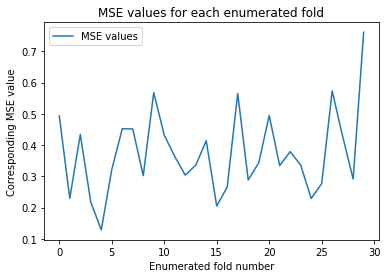

In [ ]:
###################################################
## Plotting the MSE values evaluated at each fold
###################################################

plt.plot(np.arange(len(results)),results, label = "MSE values")
plt.title("MSE values for each enumerated fold")
plt.xlabel("Enumerated fold number")
plt.ylabel("Corresponding MSE value")
plt.legend()
plt.savefig("mse_crossvalid.png")

The above results and the supporting figure suggests that the model performs well on an average. So, we can proceed with this network architecture with the parameters as considered. 

In the next segment, we train the model over a random train-test split and plot the training curve, and evaluate the model's performance based on the MSE over the test data set, as well as by comparing the score predicted by the model with the actual mean relationship score. 

In [ ]:
n_inputs, n_outputs = X.shape[1], 1
model = mlp_model(n_inputs, n_outputs)

######################
## Train test split
######################
X_train, X_test, y_train, y_test = train_test_split(X[:-1], y[:-1], test_size=0.3, random_state=42)

#####################################################################
## Fitting the model on training data and storing the loss values
#####################################################################
h = model.fit(X_train, y_train, verbose = 0, epochs = 100)
loss_values = h.history['loss']
epochs = range(1, len(loss_values)+1)

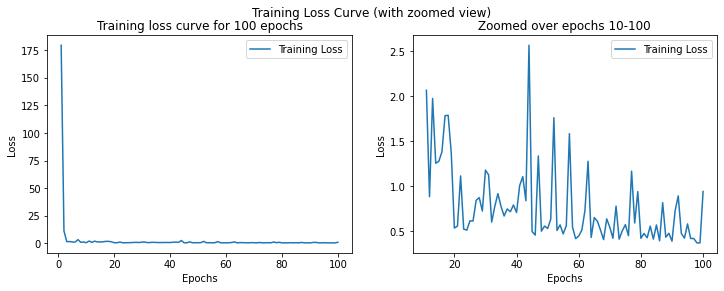

In [ ]:
######################################################
## Plotting the train loss over the epochs considered
######################################################

fig,ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(epochs[:], loss_values[:], label='Training Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title("Training loss curve for 100 epochs")
ax[0].legend()

ax[1].plot(epochs[10:], loss_values[10:], label='Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title("Zoomed over epochs 10-100")
ax[1].legend()

fig.suptitle("Training Loss Curve (with zoomed view)")
plt.savefig('Trainloss.png')

## Model Evaluation based on the test data set

In [ ]:
print("MSE evaluated on the chosen model: ", model.evaluate(X_test, y_test, verbose = 0))

MSE evaluated on the chosen model:  0.6352763772010803


## Looking at the prediction by the model based on an unseen data point

We kept the last observation in the data set out of the train-test split for this purpose. The predicted and observed values are being shown below:


In [ ]:
X_random = X[-1:]
pred_random = model.predict(X_random)
print("\033[1m Predicted Score: \033[0m", min(5.0,pred_random[0][0]))
print("\033[1m Actual score: \033[0m",y[-1:].values[0])


 Predicted Score:  5.0
 Actual score:  4.5


# **Implementation of Multiple Linear Regression and its modified versions**

---



---



Idea is to implement and see different versions of linear regression on the dataset.


---


Models tried:


*   Multiple Linear Regression
*   Non-Linear Multiple Regression with degree 2 and 3
*   Multiple Linear Regression with additional variables which are function of existing variables


---


Results Observed:
*   Increasing the degree of polynomial in Non-Linear Multiple Regression lead to decrease in train error but increase in test error drastically
*   Addition of variables like similarity and dissimilarity and implementing Multiple Linear Regression led to decrease in both train and test error in most of the cases.



## Subsetting the dataset as per requirement of Multiple Linear Regression Model

In [ ]:
def data_preprocessing(data):
    '''
        Input: Dataframe containing all the non-redundant columns 
        Extracts the relevant columns for our analysis. Those include the trait scores (standardized) and the relationship satisfaction scores.
        Also drops the NaN responses in the extracted dataframe and returns the clean processed data.
        Output: Feature matrix X containing only the relevant data columns, Response variables (satisfaction scores of both male and female) 
    '''
    reqd_data = data[["mean neuroticism female","mean neuroticism male","mean extraversion female","mean extraversion male","mean openness female","mean openness male","mean agreeableness female","mean agreeableness male","mean conscientiousness female","mean conscientiousness male","mean relationship satisfaction female","mean relationship satisfaction male"]]
    reqd_data = reqd_data.dropna() 
    reqd_data['mean relationship satisfaction'] = reqd_data[reqd_data.columns[-2:]].mean(axis = 1)
    df = reqd_data.drop(columns=["mean relationship satisfaction female","mean relationship satisfaction male"])
    return df
df = data_preprocessing(data)

## Seperating dataset into x(dependent variables) and y(independent variables)

In [ ]:
x = df[df.columns[:-1]]
y = df['mean relationship satisfaction']

# Adding a similarity variable and a dissimilarity variable with respect to the vectors of traits of male and female on the basis of Euclidian norm

cols = cols = df.columns                       # to store column names

x["sim_1"] = (x[cols[0]]-x[cols[1]])**2
x["sim_2"] = (x[cols[2]]-x[cols[3]])**2
x["sim_3"] = (x[cols[4]]-x[cols[5]])**2
x["sim_4"] = (x[cols[6]]-x[cols[7]])**2
x["sim_5"] = (x[cols[8]]-x[cols[9]])**2

x["dissimilarity"] = x["sim_1"] + x["sim_2"] + x["sim_3"] + x["sim_4"] + x["sim_5"]
x["dissimilarity"] = x["dissimilarity"]**(0.5)
x["similarity"] = x["dissimilarity"]+1
x["similarity"] = x["similarity"]**(-1)

x = x.drop(columns=["sim_1","sim_2","sim_3","sim_4","sim_5"])
x_mod = x                   # storing the modified data with additional variables
x = x_mod.drop(columns=["similarity","dissimilarity"])

## Train,Test Splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train_mod, x_test_mod, y_train_mod, y_test_mod = train_test_split(x_mod, y, test_size=0.3, random_state=42)

## Implementing Multiple Linear Regression

Train mse -  0.33036924427137726
Test mse -  0.21818724468123735


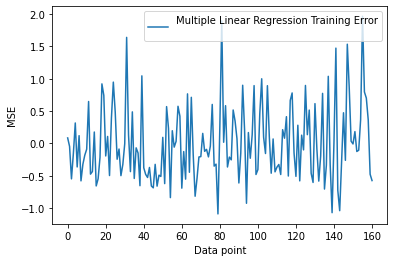

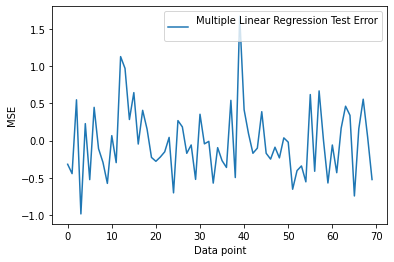

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
train_error = y_pred_train - y_train

plt.figure()
plt.plot(np.arange(len(train_error)), train_error, label = "Multiple Linear Regression Training Error\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_train = np.mean((y_pred_train-y_train)**2)
print("Train mse - ",mse_train)

plt.figure()
y_pred_test = model.predict(x_test)
test_error = y_pred_test - y_test
plt.plot(np.arange(len(test_error)), test_error, label = "Multiple Linear Regression Test Error\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_test = np.mean((y_pred_test-y_test)**2)
print("Test mse - ",mse_test)

## Implementing Non-Linear Regression

### Degree of Polynomial - 2

Train mse -  0.21273005867328135
Test mse -  0.9411589257474618


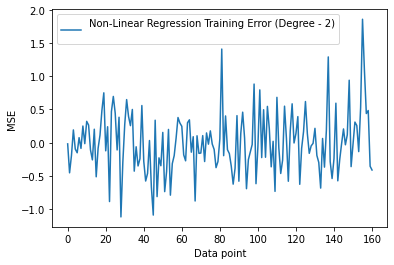

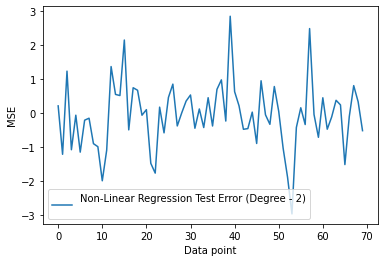

In [ ]:
poly = PolynomialFeatures(degree=2)

x_train_new = poly.fit_transform(x_train)
x_test_new = poly.fit_transform(x_test)

model = LinearRegression()
model.fit(x_train_new, y_train)

y_pred_train = model.predict(x_train_new)
train_error = y_pred_train - y_train

plt.figure()
plt.plot(np.arange(len(train_error)), train_error, label = "Non-Linear Regression Training Error (Degree - 2)\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_train = np.mean((y_pred_train-y_train)**2)
print("Train mse - ",mse_train)

y_pred_test = model.predict(x_test_new)
test_error = y_pred_test - y_test

plt.figure()
plt.plot(np.arange(len(test_error)), test_error, label = "Non-Linear Regression Test Error (Degree - 2)\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_test = np.mean((y_pred_test-y_test)**2)
print("Test mse - ",mse_test)

### Degree of Polynomial - 3

Train mse -  1.1656373183645865e-26
Test mse -  41.04949218416693


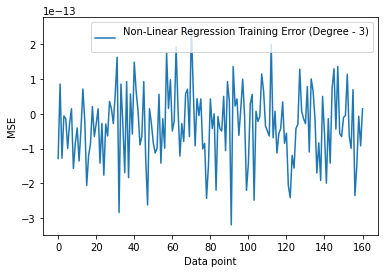

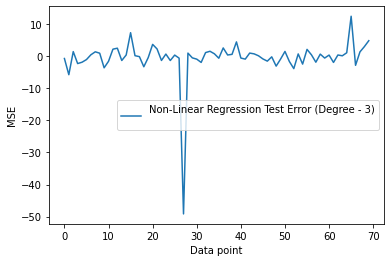

In [ ]:
poly = PolynomialFeatures(degree=3)

x_train_new = poly.fit_transform(x_train)
x_test_new = poly.fit_transform(x_test)

model = LinearRegression()
model.fit(x_train_new, y_train)

y_pred_train = model.predict(x_train_new)
train_error = y_pred_train - y_train

plt.figure()
plt.plot(np.arange(len(train_error)), train_error, label = "Non-Linear Regression Training Error (Degree - 3)\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_train = np.mean((y_pred_train-y_train)**2)
print("Train mse - ",mse_train)

y_pred_test = model.predict(x_test_new)
test_error = y_pred_test - y_test

plt.figure()
plt.plot(np.arange(len(test_error)), test_error, label = "Non-Linear Regression Test Error (Degree - 3)\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_test = np.mean((y_pred_test-y_test)**2)
print("Test mse - ",mse_test)

## Implementing Multiple Linear Regression with additional variables which are function of existing variables

Train mse -  0.31843336185363735
Test mse -  0.2304037523107158


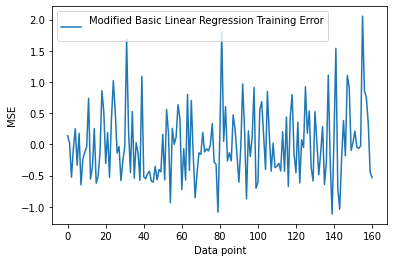

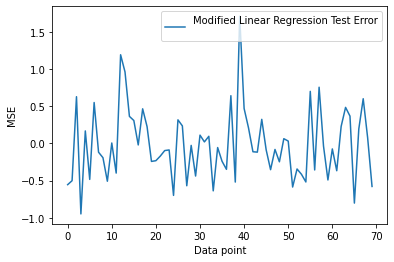

In [ ]:
model = LinearRegression()
model.fit(x_train_mod, y_train_mod)

y_pred_train_mod = model.predict(x_train_mod)
train_error = y_pred_train_mod - y_train_mod

plt.figure()
plt.plot(np.arange(len(train_error)), train_error, label = "Modified Basic Linear Regression Training Error\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_train = np.mean((y_pred_train_mod-y_train_mod)**2)
print("Train mse - ",mse_train)

y_pred_test_mod = model.predict(x_test_mod)
test_error = y_pred_test_mod - y_test_mod

plt.figure(2)
plt.plot(np.arange(len(test_error)), test_error, label = "Modified Linear Regression Test Error\n")
plt.xlabel("Data point")
plt.ylabel("MSE")
plt.legend()

mse_test = np.mean((y_pred_test_mod-y_test_mod)**2)
print("Test mse - ",mse_test)